# Dog Heart Vertebral Heart Size Point Detection
# 1. Build an object detection model using pytorch

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
path_to_dataset = "/content/drive/MyDrive/OneDrive_1_11-25-2024.zip"

In [ ]:
import zipfile
import os

# Define the path to the main ZIP file and the destination directory
path_to_dataset = "/content/drive/MyDrive/OneDrive_1_11-25-2024.zip"
destination_dir = "/content"

def extract_zip(file_path, extract_to):
    """
    Extracts a zip file and recursively extracts any zip files within it.
    """
    # Ensure the destination directory exists
    os.makedirs(extract_to, exist_ok=True)

    # Extract the main zip file
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Extracted: {file_path}")

    # Recursively extract any nested zip files
    for root, _, files in os.walk(extract_to):
        for file in files:
            if file.endswith('.zip'):
                nested_zip_path = os.path.join(root, file)
                nested_extract_to = os.path.splitext(nested_zip_path)[0]  # Extract to a folder named after the zip
                extract_zip(nested_zip_path, nested_extract_to)  # Recursively extract
                os.remove(nested_zip_path)  # Optionally remove the nested zip file after extraction

# Extract the main zip file
extract_zip(path_to_dataset, destination_dir)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/OneDrive_1_11-25-2024.zip'

In [ ]:
pip install --upgrade sympy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 49.1 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu121 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.13.3 which is incompatible.


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torch.optim.lr_scheduler import StepLR
from PIL import Image
from scipy.io import loadmat
from torchvision import transforms as T




# DO NOT MODIFY THE FOLLOWING CODE
class DogHeartDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))
        self.points = list(sorted(os.listdir(os.path.join(root, "Labels"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        points_path = os.path.join(self.root, "Labels", self.points[idx])
        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        if self.transforms is not None:
            img = self.transforms(img)
        h_new, w_new = img.shape[1], img.shape[2]
        mat = loadmat(points_path)
        six_points = mat['six_points'].astype(float)
        six_points = torch.as_tensor(six_points, dtype=torch.float32)
        six_points[:, 0] = w_new / w * six_points[:, 0]  # Resize image to any size and maintain original points
        six_points[:, 1] = h_new / h * six_points[:, 1]
        six_points = torch.reshape(six_points, (-1,)) / h_new  # Normalize the points
        VHS = mat['VHS'].astype(float)
        VHS = torch.as_tensor(VHS, dtype=torch.float32)
        return img, six_points, VHS

    def __len__(self):
        return len(self.imgs)


def get_transform(resized_image_size):
    transforms = []
    transforms.append(T.ToTensor())
    transforms.append(T.Resize(size=(resized_image_size, resized_image_size)))
    transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    return T.Compose(transforms)

# Training Settings
batch_size = 8
resized_image_size = 512
num_epochs = 30

# Initialize datasets and dataloaders
dataset_train = DogHeartDataset('/content/drive/MyDrive/OneDrive_1_11-25-2024/Train', get_transform(resized_image_size))
data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_valid = DogHeartDataset('/content/drive/MyDrive/OneDrive_1_11-25-2024/Valid', get_transform(resized_image_size))
data_loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

# Define the model
class PointRegressionModel(nn.Module):
    def __init__(self, num_points=12):
        super(PointRegressionModel, self).__init__()
        self.backbone = resnet50(weights='ResNet50_Weights.DEFAULT')
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_points)

    def forward(self, x):
        return self.backbone(x)

model = PointRegressionModel(num_points=12).to('cuda')

# Loss Function: Weighted MSE Loss
def weighted_mse_loss(predictions, targets, weights):
    return torch.mean(weights * (predictions - targets) ** 2)

weights = torch.tensor([2, 2, 1, 1, 1, 1]).repeat(2).to('cuda')  # Higher weight for long axis points

# Optimizer and Scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Training Loop
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0.0
    for images, keypoints, _ in data_loader_train:
        images, keypoints = images.to('cuda'), keypoints.to('cuda')

        optimizer.zero_grad()
        predictions = model(images)
        loss = weighted_mse_loss(predictions, keypoints, weights)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation Phase
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for images, keypoints, _ in data_loader_valid:
            images, keypoints = images.to('cuda'), keypoints.to('cuda')
            predictions = model(images)
            loss = weighted_mse_loss(predictions, keypoints, weights)
            valid_loss += loss.item()

    # Scheduler Step
    scheduler.step()

    # Logging
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss / len(data_loader_train):.4f}")
    print(f"Valid Loss: {valid_loss / len(data_loader_valid):.4f}")

# Save the Model
torch.save(model.state_dict(), "/content/PointRegressionModel.pth")
print("Model saved to /content/PointRegressionModel.pth")

Epoch 1/30
Train Loss: 0.0101
Valid Loss: 0.0019
Epoch 2/30
Train Loss: 0.0020
Valid Loss: 0.0017
Epoch 3/30
Train Loss: 0.0012
Valid Loss: 0.0014
Epoch 4/30
Train Loss: 0.0009
Valid Loss: 0.0010
Epoch 5/30
Train Loss: 0.0007
Valid Loss: 0.0008
Epoch 6/30
Train Loss: 0.0006
Valid Loss: 0.0008
Epoch 7/30
Train Loss: 0.0005
Valid Loss: 0.0007
Epoch 8/30
Train Loss: 0.0005
Valid Loss: 0.0008
Epoch 9/30
Train Loss: 0.0005
Valid Loss: 0.0007
Epoch 10/30
Train Loss: 0.0004
Valid Loss: 0.0009
Epoch 11/30
Train Loss: 0.0002
Valid Loss: 0.0005
Epoch 12/30
Train Loss: 0.0002
Valid Loss: 0.0005
Epoch 13/30
Train Loss: 0.0001
Valid Loss: 0.0005
Epoch 14/30
Train Loss: 0.0001
Valid Loss: 0.0005
Epoch 15/30
Train Loss: 0.0001
Valid Loss: 0.0004
Epoch 16/30
Train Loss: 0.0001
Valid Loss: 0.0004
Epoch 17/30
Train Loss: 0.0001
Valid Loss: 0.0005
Epoch 18/30
Train Loss: 0.0001
Valid Loss: 0.0004
Epoch 19/30
Train Loss: 0.0001
Valid Loss: 0.0005
Epoch 20/30
Train Loss: 0.0001
Valid Loss: 0.0005
Epoch 21/

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from timm.models.vision_transformer import vit_base_patch16_224
from timm.models.layers import trunc_normal_

# Dataset Class
class DogHeartDataset:
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, "Images")))
        self.points = sorted(os.listdir(os.path.join(root, "Labels")))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        label_path = os.path.join(self.root, "Labels", self.points[idx])
        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        img = self.transforms(img)
        mat = loadmat(label_path)
        six_points = mat['six_points'].astype(float)
        six_points = torch.as_tensor(six_points, dtype=torch.float32)
        six_points[:, 0] *= img.shape[2] / w
        six_points[:, 1] *= img.shape[1] / h
        six_points = torch.flatten(six_points) / img.shape[1]
        VHS = mat['VHS'].astype(float)
        VHS = torch.tensor(VHS, dtype=torch.float32)
        return img, six_points, VHS

    def __len__(self):
        return len(self.imgs)

# Transform Function
def get_transform(resized_image_size=224):
    return Compose([
        Resize((resized_image_size, resized_image_size)),  # Resize to 224x224
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# RVT Model
class RVT(nn.Module):
    def __init__(self, num_points=12):
        super(RVT, self).__init__()
        self.backbone = vit_base_patch16_224(pretrained=True)
        self.backbone.head = nn.Linear(self.backbone.head.in_features, 512)
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_points),
        )
        trunc_normal_(self.fc[-1].weight, std=0.02)

    def forward(self, x):
        features = self.backbone(x)
        points = self.fc(features)
        return points

# Training Configuration
batch_size = 8
resized_image_size = 224  # Change from 512 to 224
num_epochs = 100
learning_rate = 3e-5
gamma = 0.01

# Load Dataset
train_dataset = DogHeartDataset('/content/drive/MyDrive/OneDrive_1_11-25-2024/Train', get_transform(resized_image_size))
valid_dataset = DogHeartDataset('/content/drive/MyDrive/OneDrive_1_11-25-2024/Valid', get_transform(resized_image_size))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Initialize Model, Optimizer, Loss
model = RVT(num_points=12).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
best_valid_loss = float('inf')

# Training Loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, keypoints, _ in train_loader:
        images, keypoints = images.to('cuda'), keypoints.to('cuda')

        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, keypoints)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation Loop
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for images, keypoints, _ in valid_loader:
            images, keypoints = images.to('cuda'), keypoints.to('cuda')
            predictions = model(images)
            loss = criterion(predictions, keypoints)
            valid_loss += loss.item()

    # Logging
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Valid Loss: {valid_loss / len(valid_loader):.4f}")

    # Save Model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "RVT_model.pth")
        print("Model saved!")

print("Training Complete!")


Epoch 1/100, Train Loss: 0.0272, Valid Loss: 0.0050
Model saved!
Epoch 2/100, Train Loss: 0.0163, Valid Loss: 0.0029
Model saved!
Epoch 3/100, Train Loss: 0.0131, Valid Loss: 0.0023
Model saved!
Epoch 4/100, Train Loss: 0.0103, Valid Loss: 0.0015
Model saved!
Epoch 5/100, Train Loss: 0.0088, Valid Loss: 0.0015
Epoch 6/100, Train Loss: 0.0082, Valid Loss: 0.0022
Epoch 7/100, Train Loss: 0.0072, Valid Loss: 0.0009
Model saved!
Epoch 8/100, Train Loss: 0.0069, Valid Loss: 0.0030
Epoch 9/100, Train Loss: 0.0063, Valid Loss: 0.0010
Epoch 10/100, Train Loss: 0.0064, Valid Loss: 0.0014
Epoch 11/100, Train Loss: 0.0055, Valid Loss: 0.0009
Epoch 12/100, Train Loss: 0.0051, Valid Loss: 0.0007
Model saved!
Epoch 13/100, Train Loss: 0.0050, Valid Loss: 0.0016
Epoch 14/100, Train Loss: 0.0049, Valid Loss: 0.0007
Model saved!
Epoch 15/100, Train Loss: 0.0048, Valid Loss: 0.0009
Epoch 16/100, Train Loss: 0.0049, Valid Loss: 0.0007
Model saved!
Epoch 17/100, Train Loss: 0.0044, Valid Loss: 0.0008
Epoc

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader
from PIL import Image
import os
from scipy.io import loadmat
from timm.models.vision_transformer import vit_base_patch16_224
from timm.models.layers import trunc_normal_
import numpy as np

# Dataset Class
class DogHeartDataset:
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, "Images")))
        self.points = sorted(os.listdir(os.path.join(root, "Labels")))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        label_path = os.path.join(self.root, "Labels", self.points[idx])
        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        img = self.transforms(img)
        mat = loadmat(label_path)
        six_points = mat['six_points'].astype(float)
        six_points = torch.as_tensor(six_points, dtype=torch.float32)
        six_points[:, 0] *= img.shape[2] / w
        six_points[:, 1] *= img.shape[1] / h
        six_points = torch.flatten(six_points) / img.shape[1]
        VHS = mat['VHS'].astype(float)
        VHS = torch.tensor(VHS, dtype=torch.float32)
        return img, six_points, VHS

    def __len__(self):
        return len(self.imgs)

# Transform Function
def get_transform(resized_image_size=224):
    return Compose([
        Resize((resized_image_size, resized_image_size)),  # Resize to 224x224
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# RVT Model
class RVT(nn.Module):
    def __init__(self, num_points=12):
        super(RVT, self).__init__()
        self.backbone = vit_base_patch16_224(pretrained=True)
        self.backbone.head = nn.Linear(self.backbone.head.in_features, 512)
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_points),
        )
        trunc_normal_(self.fc[-1].weight, std=0.02)

    def forward(self, x):
        features = self.backbone(x)
        points = self.fc(features)
        return points

# Training Configuration
batch_size = 8
resized_image_size = 224  # Change from 512 to 224
num_epochs = 150
learning_rate = 3e-5
gamma = 0.01

# Load Dataset
train_dataset = DogHeartDataset('/content/drive/MyDrive/OneDrive_1_11-25-2024/Train', get_transform(resized_image_size))
valid_dataset = DogHeartDataset('/content/drive/MyDrive/OneDrive_1_11-25-2024/Valid', get_transform(resized_image_size))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Initialize Model, Optimizer, Loss
model = RVT(num_points=12).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Load Saved Model
saved_model_path = "/content/drive/MyDrive/RVT_model.pth"
if os.path.exists(saved_model_path):
    print(f"Loading saved model from {saved_model_path}...")
    model.load_state_dict(torch.load(saved_model_path))
    print("Model loaded successfully!")

# Training Loop
best_valid_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, keypoints, _ in train_loader:
        images, keypoints = images.to('cuda'), keypoints.to('cuda')

        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, keypoints)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation Loop
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for images, keypoints, _ in valid_loader:
            images, keypoints = images.to('cuda'), keypoints.to('cuda')
            predictions = model(images)
            loss = criterion(predictions, keypoints)
            valid_loss += loss.item()

    # Logging
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Valid Loss: {valid_loss / len(valid_loader):.4f}")

    save_path = "/content/drive/MyDrive/RVT_model.pth"

    # Save Model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),save_path)
        print("Model saved!")

print("Training Complete!")


/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Loading saved model from /content/drive/MyDrive/RVT_model.pth...


<ipython-input-2-6c22633f6d8d>:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(saved_model_path))


Model loaded successfully!
Epoch 1/150, Train Loss: 0.0006, Valid Loss: 0.0003
Model saved!
Epoch 2/150, Train Loss: 0.0006, Valid Loss: 0.0004
Epoch 3/150, Train Loss: 0.0006, Valid Loss: 0.0003
Epoch 4/150, Train Loss: 0.0006, Valid Loss: 0.0003


KeyboardInterrupt: 

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
import torch.nn as nn
from timm.models.vision_transformer import vit_base_patch16_224

# Corrected model definition matching training structure
class RVT(nn.Module):
    def __init__(self, num_points=12):
        super(RVT, self).__init__()
        self.backbone = vit_base_patch16_224(pretrained=False)
        self.backbone.head = nn.Linear(self.backbone.head.in_features, 512)
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_points),
        )

    def forward(self, x):
        features = self.backbone(x)
        points = self.fc(features)
        return points

# Load the trained model
model_path = "/content/drive/MyDrive/RVT_model.pth"
try:
    model = RVT(num_points=12).to('cuda')
    model.load_state_dict(torch.load(model_path, map_location='cuda'))
    model.eval()
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Define test dataset transforms
def get_test_transform(resized_image_size):
    return Compose([
        Resize((resized_image_size, resized_image_size)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

resized_image_size = 224
test_transform = get_test_transform(resized_image_size)

# Path to test images
test_images_path = "/content/drive/MyDrive/OneDrive_1_11-25-2024/Test_Images/Images"

# Function to calculate VHS and round to 4 decimal places
def calculate_vhs(predicted_points, width, height):
    # Rescale normalized points back to original image dimensions
    predicted_points = predicted_points.view(-1, 2)
    predicted_points[:, 0] *= width
    predicted_points[:, 1] *= height

    # Extract key points for VHS calculation
    A, B = predicted_points[0], predicted_points[1]  # Long axis points
    C, D = predicted_points[2], predicted_points[3]  # Short axis points
    E, F = predicted_points[4], predicted_points[5]  # Vertebral reference points

    # Calculate distances (Euclidean)
    AB_length = torch.sqrt(torch.sum((B - A) ** 2))
    CD_length = torch.sqrt(torch.sum((D - C) ** 2))
    EF_length = torch.sqrt(torch.sum((F - E) ** 2))

    # Compute VHS and round to 4 decimal places
    VHS = 6 * (AB_length + CD_length) / EF_length
    return round(VHS.item(), 4)

# Prepare results list
results = []

# Check if test images are available
if not os.path.exists(test_images_path) or len(os.listdir(test_images_path)) == 0:
    print(f"No test images found in {test_images_path}.")
    raise FileNotFoundError("Ensure the test images are in the specified directory.")

# Iterate over test images
for filename in sorted(os.listdir(test_images_path)):
    if filename.endswith(".png"):  # Ensure only .png files are processed
        print(f"Processing {filename}...")

        # Load and preprocess the test image
        img_path = os.path.join(test_images_path, filename)
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
            continue

        width, height = img.size
        img_tensor = test_transform(img).unsqueeze(0).to('cuda')

        # Predict points and calculate VHS
        try:
            with torch.no_grad():
                prediction = model(img_tensor).cpu().squeeze()

            # Validate prediction
            if prediction.numel() != 12:
                print(f"Invalid prediction for {filename}. Skipping.")
                continue

            print(f"Prediction for {filename}: {prediction.tolist()}")

            # Calculate VHS score
            predicted_vhs = calculate_vhs(prediction, width, height)
            results.append({"Filename": filename, "VHS": predicted_vhs})
        except Exception as e:
            print(f"Error generating prediction for {filename}: {e}")
            continue

# Save results to CSV
if results:  # Check if there are any results to save
    results_df = pd.DataFrame(results)
    output_path = "/content/VHS_results.csv"
    results_df.to_csv(output_path, index=False,header=False)  # With header for clarity
    print(f"Results saved to {output_path}")
else:
    print("No results to save. Check if predictions are being generated.")


<ipython-input-4-fad397ddb155>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location='cuda'))


Model loaded successfully!
Processing 100.png...
Prediction for 100.png: [0.4727931618690491, 0.4792190194129944, 0.5171756744384766, 0.7562882900238037, 0.3770447373390198, 0.6313192248344421, 0.5620520114898682, 0.5613183379173279, 0.4122188687324524, 0.39883536100387573, 0.6613192558288574, 0.28091418743133545]
Processing 1621.png...
Prediction for 1621.png: [0.3929450213909149, 0.5215851068496704, 0.5084990859031677, 0.8879648447036743, 0.25319212675094604, 0.719825267791748, 0.5152609944343567, 0.6030865907669067, 0.2795960307121277, 0.3745995759963989, 0.6217041611671448, 0.27142584323883057]
Processing 1622.png...
Prediction for 1622.png: [0.4837108850479126, 0.5614980459213257, 0.6630190014839172, 0.8636237382888794, 0.42400166392326355, 0.7715814113616943, 0.6124315857887268, 0.6101165413856506, 0.28949570655822754, 0.46699613332748413, 0.7066075801849365, 0.32348155975341797]
Processing 1623.png...
Prediction for 1623.png: [0.46702146530151367, 0.559730052947998, 0.6416032910

# 2. Train your model using [Dog VHS Dataset](https://yuad-my.sharepoint.com/:f:/g/personal/youshan_zhang_yu_edu/ErguFJBE4y9KqzEdWWNlXzMBkTbsBaNX9l856SyvQauwJg?e=L3JOuN)

# 3.Evaluate your model using the test images with the [software](https://github.com/YoushanZhang/Dog-Cardiomegaly_VHS)

# 4. Your results should be achieved 85%. VHS = 6(AB+CD)/EF

## (10 points, accuracy < 75% --> 0 points)

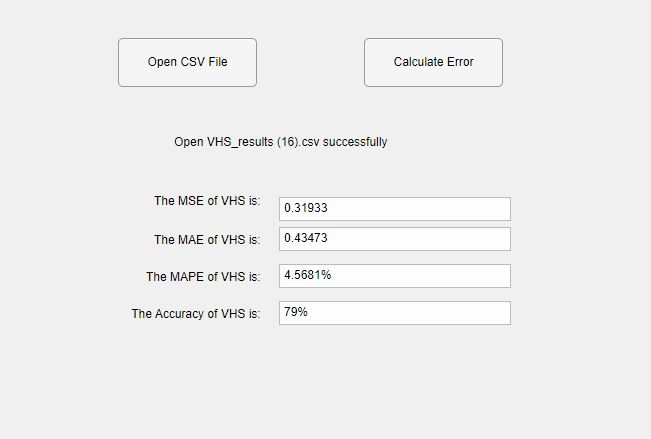

##Model link

In [ ]:
https://drive.google.com/file/d/1G3D2Pk9cUiMH4BMXld1OQLk-bioTNKAI/view?usp=sharing

#Research Paper Link

In [ ]:
https://www.researchgate.net/publication/386425457_Automation_of_Vertebral_Heart_Size_Detection_in_Canine_Radiographs_Using_Deep_Learning_Frameworks

# 5. Show the comprison between predictions and ground truth
## You need to add the title with: image name, predicted VHS and Ground Truth VHS
<p align="center">
  <img src="Com.png" width="60%">
</p>


# Please show the comprison results of images: 1420.png, 1479.png and 1530.png from Valid dataset

<ipython-input-3-c6eddc63a24b>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location='cuda'))


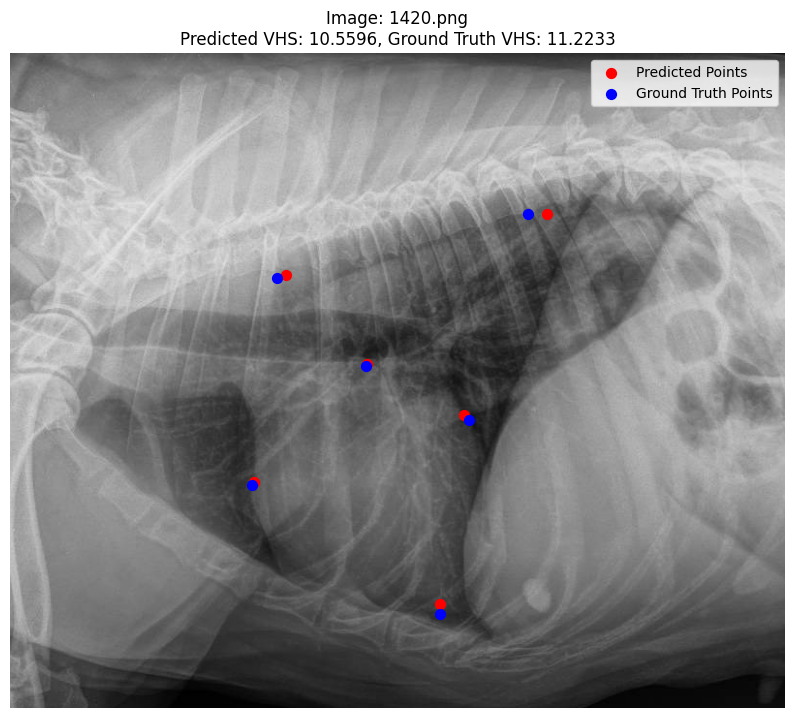

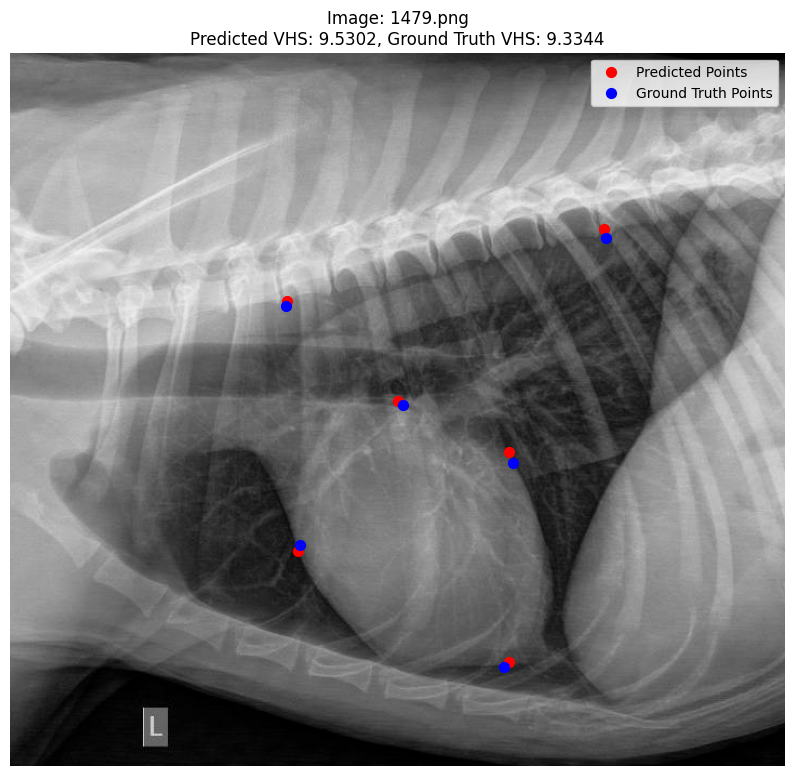

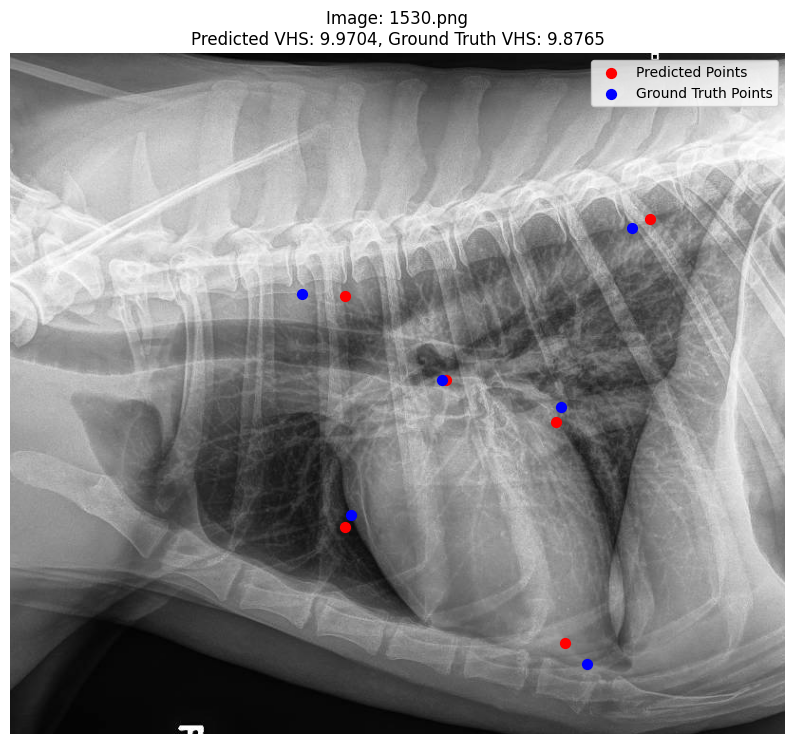

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import os

# Function to visualize predictions vs. ground truth
def visualize_predictions_rvt(model, dataset, image_names, resized_image_size):
    # Set the model to evaluation mode
    model.eval()

    # Transformation function (from dataset transform)
    transform = get_transform(resized_image_size)

    for image_name in image_names:
        # Find the index of the image in the dataset
        try:
            img_idx = dataset.imgs.index(image_name)
        except ValueError:
            print(f"Image {image_name} not found in the dataset.")
            continue

        # Load image and ground truth
        img, ground_truth_points, ground_truth_vhs = dataset[img_idx]

        # Prepare image tensor
        img_tensor = img.unsqueeze(0).to('cuda')

        # Generate predictions
        with torch.no_grad():
            predicted_points = model(img_tensor).cpu().squeeze()

        # Rescale predictions and ground truth back to original image dimensions
        img_original = Image.open(os.path.join(dataset.root, "Images", image_name)).convert("RGB")
        width, height = img_original.size
        predicted_points = predicted_points.view(-1, 2).numpy()
        ground_truth_points = ground_truth_points.view(-1, 2).numpy()

        # Rescale coordinates to match the original image dimensions
        predicted_points[:, 0] *= width
        predicted_points[:, 1] *= height
        ground_truth_points[:, 0] *= width
        ground_truth_points[:, 1] *= height

        # Calculate predicted VHS
        def calculate_vhs(points):
            A, B = points[0], points[1]  # Long axis
            C, D = points[2], points[3]  # Short axis
            E, F = points[4], points[5]  # Reference points
            AB_length = np.linalg.norm(B - A)
            CD_length = np.linalg.norm(D - C)
            EF_length = np.linalg.norm(F - E)
            return round(6 * (AB_length + CD_length) / EF_length, 4)

        predicted_vhs = calculate_vhs(predicted_points)

        # Plotting
        plt.figure(figsize=(10, 10))
        plt.imshow(img_original)
        plt.scatter(predicted_points[:, 0], predicted_points[:, 1], c='r', label='Predicted Points', s=50)
        plt.scatter(ground_truth_points[:, 0], ground_truth_points[:, 1], c='b', label='Ground Truth Points', s=50)
        plt.legend()
        plt.title(
            f"Image: {image_name}\nPredicted VHS: {predicted_vhs}, Ground Truth VHS: {round(ground_truth_vhs.item(), 4)}",
            fontsize=12,
        )
        plt.axis('off')
        plt.show()

# Load RVT model
model_path = "/content/drive/MyDrive/RVT_model.pth"
model = RVT(num_points=12).to('cuda')  # Ensure this matches your RVT class
model.load_state_dict(torch.load(model_path, map_location='cuda'))

# Specify images for comparison
valid_images = ["1420.png", "1479.png", "1530.png"]

# Visualize results
visualize_predictions_rvt(model, valid_dataset, valid_images, resized_image_size)


# 6. Write a three-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


# 7. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file, prediction CSV file and add paper link)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points

# 8. Bonus points (10 points if your accuracy is higer than 87.3%)